# DNN paper analysis
Analysis leading to the plots in [Distance-Based Delays in Echo State Networks](https://link.springer.com/chapter/10.1007/978-3-031-21753-1_21).

## Imports

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import populations
from network import tanh_activation
from utils import eval_candidate_lag_gridsearch_NARMA, createNARMA10
from config import propagation_vel
sns.set_theme()
sns.set(font="times new roman", style="white", font_scale=2.1)

## Functions
Some helper functions

In [48]:
def get_evolution_info_per_candidate(data, it=99):
    data = data[:it, :, :, :]
    best_lags = np.argmin(data, axis=3)
    performance = np.min(data, axis=3)
    lags_per_cand = np.mean(best_lags, axis=2)
    performance_per_cand = np.mean(performance, axis=2)
    return performance_per_cand, lags_per_cand

def get_evolution_info_per_generation(performance_per_cand, lags_per_cand):
    average_performance = np.mean(performance_per_cand, axis=1)
    best_performance = np.min(performance_per_cand, axis=1)
    average_lag = np.mean(lags_per_cand, axis=1)
    best_lag = np.min(lags_per_cand, axis=1)
    val_per_gen = {'Average performance': average_performance, 'Best performance': best_performance}
    lag_per_gen = {'Average lag': average_lag, 'Best lag': best_lag}
    return val_per_gen, lag_per_gen 

def plot_average_and_best_performance(val_per_gen, ax, title, lab_spac=0):
    ax.plot(val_per_gen['Average performance'])
    ax.plot(val_per_gen['Best performance'])
    ax.set_title(title)
    ax.set_xlabel('Generation')
    ax.set_ylabel('NRMSE')
    ax.legend(['Average of population', 'Best candidate of population'], labelspacing=lab_spac)

def plot_lag_info_across_gens(data, ax, gen_step, lab_spac):
    data = np.mean(data, axis=2)
    data = np.mean(data, axis=1)
    nr_gens = data.shape[0]
    gens = np.maximum(0, np.arange(0, nr_gens + 1, gen_step, dtype='int32') - 1)
    print(gens)
    legend = []
    for gen in gens:
        ax.plot(data[gen, :], marker='o')
        legend.append('Generation ' + str(gen))
    ax.set_xlabel('Lag (simulation steps)')
    ax.set_ylabel('NRMSE')
    ax.legend(legend, labelspacing=lab_spac)

## Data import

In [49]:
file_names = {
    'Tanh K1': ('results-2022-paper/cma_es_gmm_250322_k1_tanh_final_paper_bl.p',
                               'results-2022-paper/cma_es_gmm_200222k1_tanh_vd_reg.p'),
    'Tanh K4': ('results-2022-paper/cma_es_gmm_230222k4_tanh_bl_reg.p',
                                'results-2022-paper/cma_es_gmm_230222k4_tanh_vd_reg.p')
}

In [50]:
condition_1 = 'Tanh K1'
condition_4 = 'Tanh K4'

k = 1
N = 301

filename_bl_1 = file_names[condition_1][0]
filename_vd_1 = file_names[condition_1][1]

with open(filename_bl_1, 'rb') as file:
    data_bl_1 = pkl.load(file)

with open(filename_vd_1, 'rb') as file:
    data_vd_1 = pkl.load(file)

print(data_bl_1.keys())
print(data_vd_1.keys())

filename_bl_4 = file_names[condition_4][0]
filename_vd_4 = file_names[condition_4][1]

with open(filename_bl_4, 'rb') as file:
    data_bl_4 = pkl.load(file)

with open(filename_vd_4, 'rb') as file:
    data_vd_4 = pkl.load(file)

print(data_bl_4.keys())
print(data_vd_4.keys())


dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net'])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])


## Single Cluster Evolutions
validation score per generation for ESNs (baseline) and DDNs.

[None, None, None, None]

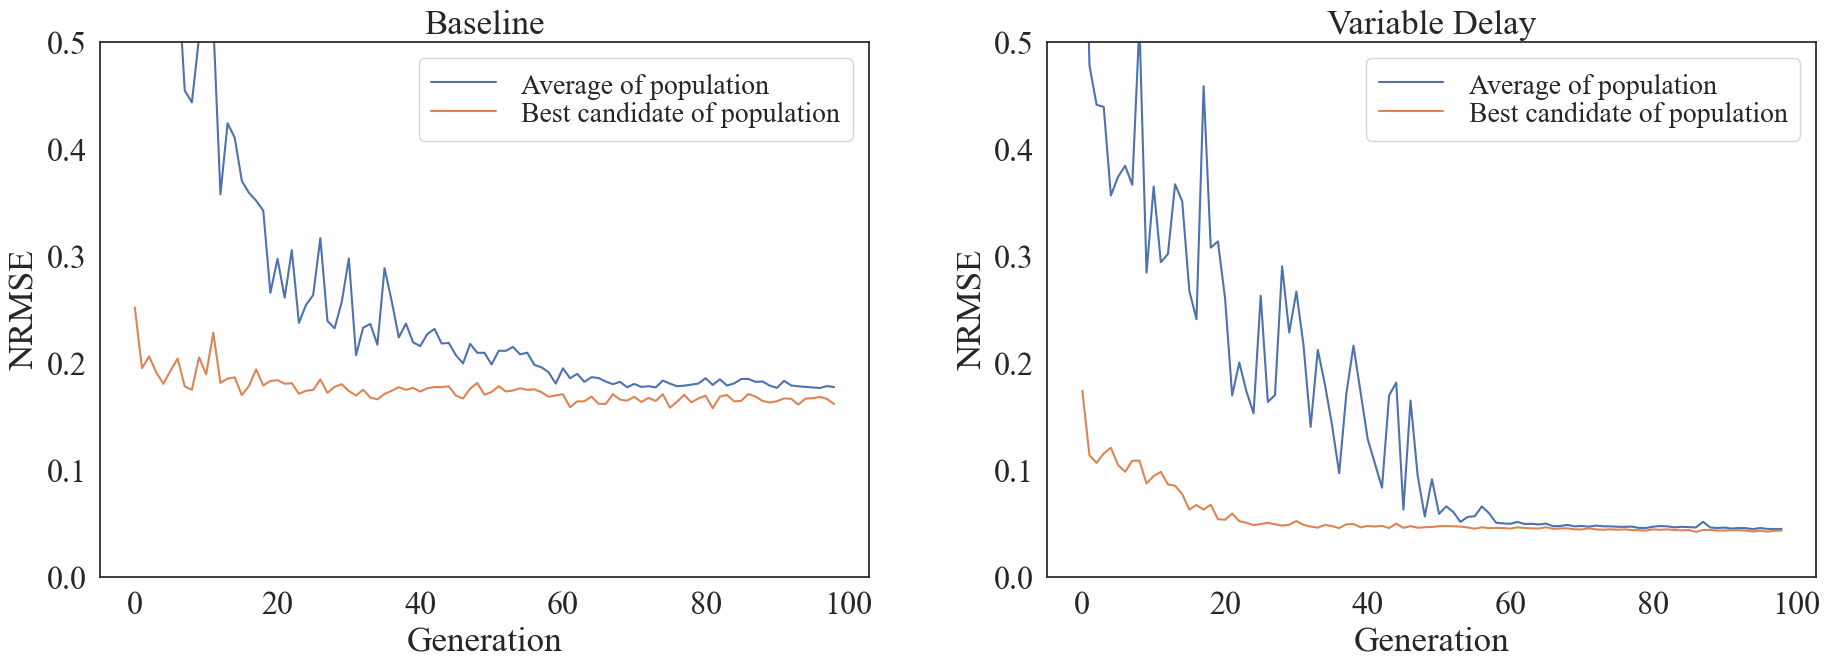

In [51]:
# Plot parameters
max_generation = 99
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.tight_layout(pad=3)
# fig.suptitle('Validation performance per generation')
y_lim = (0, 0.5)
ax[0].set_ylim(y_lim)
ax[1].set_ylim(y_lim)

# Plot Average and Best performance
val_bl = data_bl_1['validation performance']
val_vd = data_vd_1['validation performance']

val_per_cand_bl_1, lag_per_cand_bl_1 = get_evolution_info_per_candidate(val_bl, max_generation)
val_per_gen_bl_1, lag_per_gen_bl_1 = get_evolution_info_per_generation(val_per_cand_bl_1, lag_per_cand_bl_1)
plot_average_and_best_performance(val_per_gen_bl_1, ax[0], 'Baseline', 0)

val_per_cand_vd_1, lag_per_cand_vd_1 = get_evolution_info_per_candidate(val_vd, max_generation)
val_per_gen_vd_1, lag_per_gen_vd_1 = get_evolution_info_per_generation(val_per_cand_vd_1, lag_per_cand_vd_1)
plot_average_and_best_performance(val_per_gen_vd_1, ax[1], 'Variable Delay', 0)

leg_font = '20'
plt.setp(ax[0].get_legend().get_texts(), fontsize=leg_font) # for legend text
plt.setp(ax[1].get_legend().get_texts(), fontsize=leg_font) # for legend text


### Average performance per lag throughout evolution

[ 0 19 39 59 79 99]
[ 0 19 39 59 79 99]


[None, None, None, None, None, None, None, None, None, None, None, None]

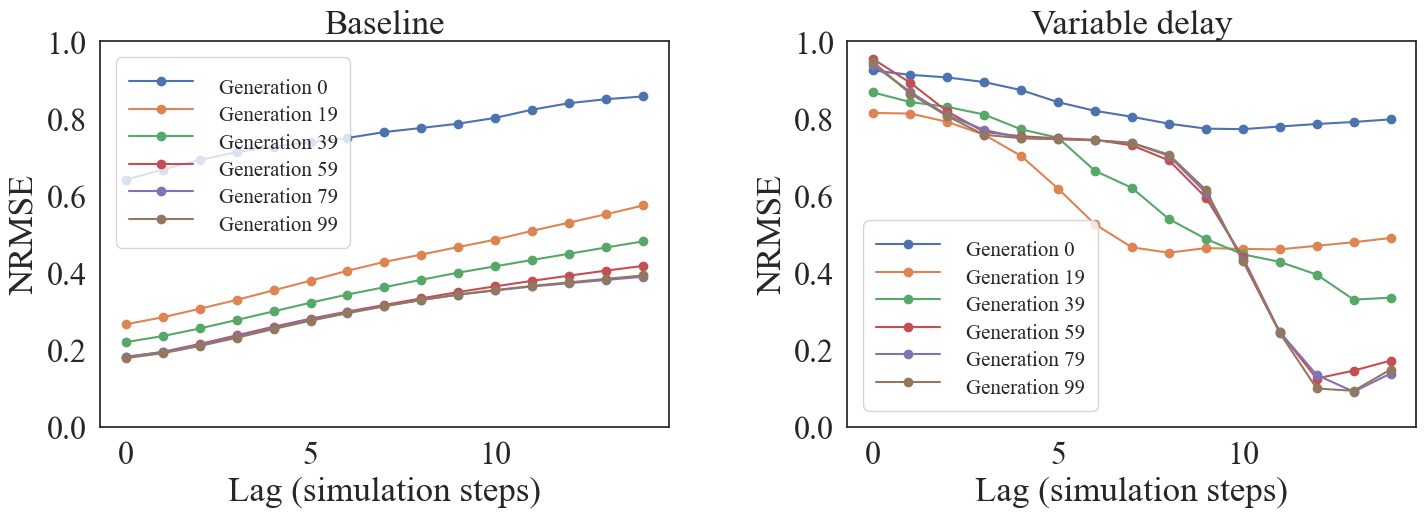

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16,6.5))
fig.tight_layout(pad=3)
gen_step = 20
plot_lag_info_across_gens(val_vd, ax[1], gen_step, 0)
plot_lag_info_across_gens(val_bl, ax[0], gen_step, 0)
ax[1].set_title('Variable delay')
ax[0].set_title('Baseline')
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
# fig.suptitle('Average performance per lag throughout evolution')
leg_font = '15'
plt.setp(ax[0].get_legend().get_texts(), fontsize=leg_font) # for legend text
plt.setp(ax[1].get_legend().get_texts(), fontsize=leg_font) # for legend text

## 4 Cluster Evolutions
validation score per generation for ESNs (baseline) and DDNs.

[None, None, None, None]

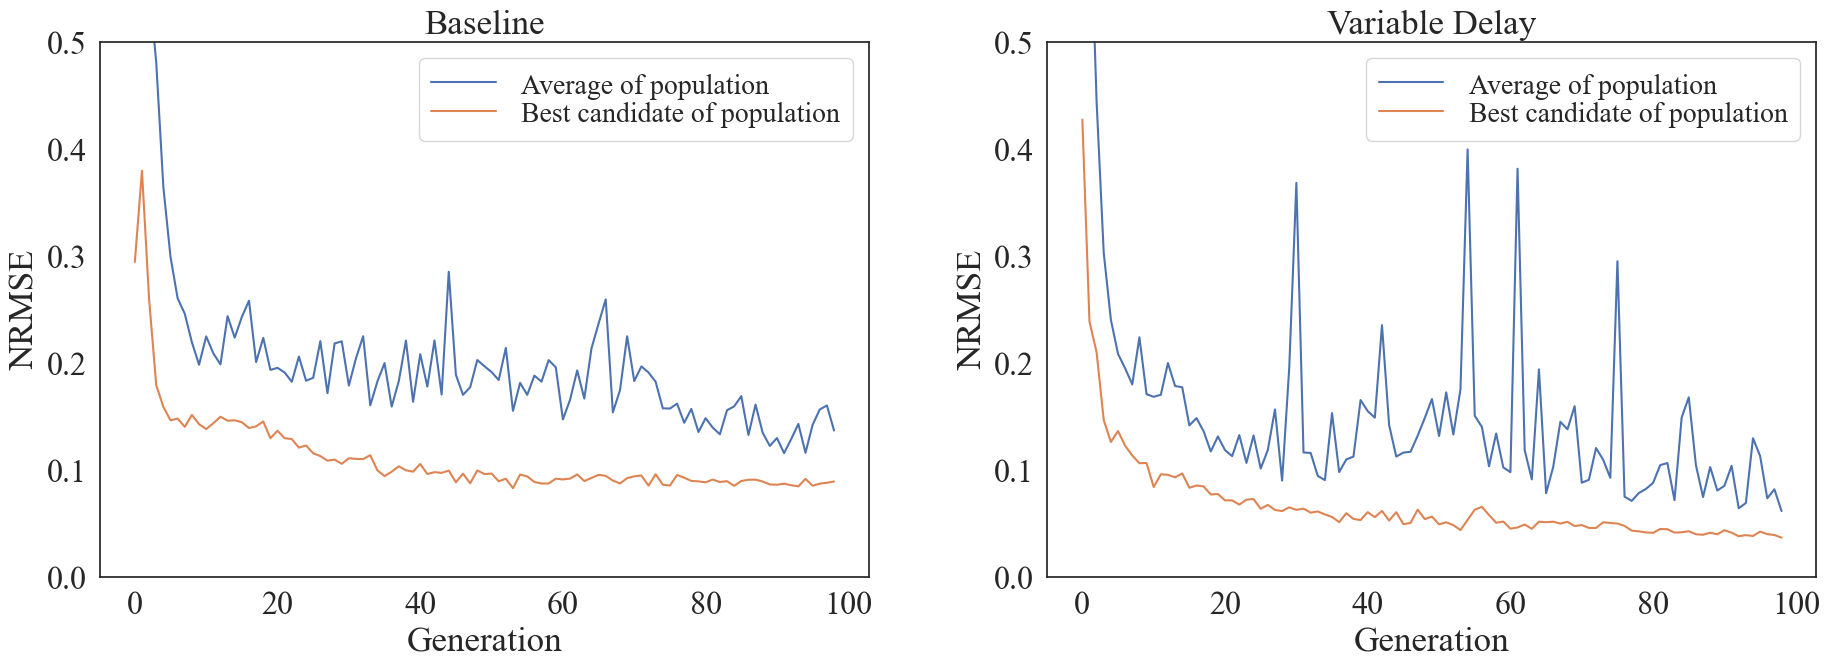

In [53]:
# Plot parameters
max_generation = 99
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.tight_layout(pad=3)
# fig.suptitle('Validation performance per generation')
y_lim = (0, 0.5)
ax[0].set_ylim(y_lim)
ax[1].set_ylim(y_lim)

# Plot Average and Best performance
val_bl = data_bl_4['validation performance']
val_vd = data_vd_4['validation performance']

val_per_cand_bl_4, lag_per_cand_bl_4 = get_evolution_info_per_candidate(val_bl, max_generation)
val_per_gen_bl_4, lag_per_gen_bl_4 = get_evolution_info_per_generation(val_per_cand_bl_4, lag_per_cand_bl_4)
plot_average_and_best_performance(val_per_gen_bl_4, ax[0], 'Baseline', 0)

val_per_cand_vd_4, lag_per_cand_vd_4 = get_evolution_info_per_candidate(val_vd, max_generation)
val_per_gen_vd_4, lag_per_gen_vd_4 = get_evolution_info_per_generation(val_per_cand_vd_4, lag_per_cand_vd_4)
plot_average_and_best_performance(val_per_gen_vd_4, ax[1], 'Variable Delay', 0)

leg_font = '20'
plt.setp(ax[0].get_legend().get_texts(), fontsize=leg_font) # for legend text
plt.setp(ax[1].get_legend().get_texts(), fontsize=leg_font) # for legend text


### Average performance per lag throughout evolution

[ 0 19 39 59 79 99]
[ 0 19 39 59 79 99]


[None, None, None, None, None, None, None, None, None, None, None, None]

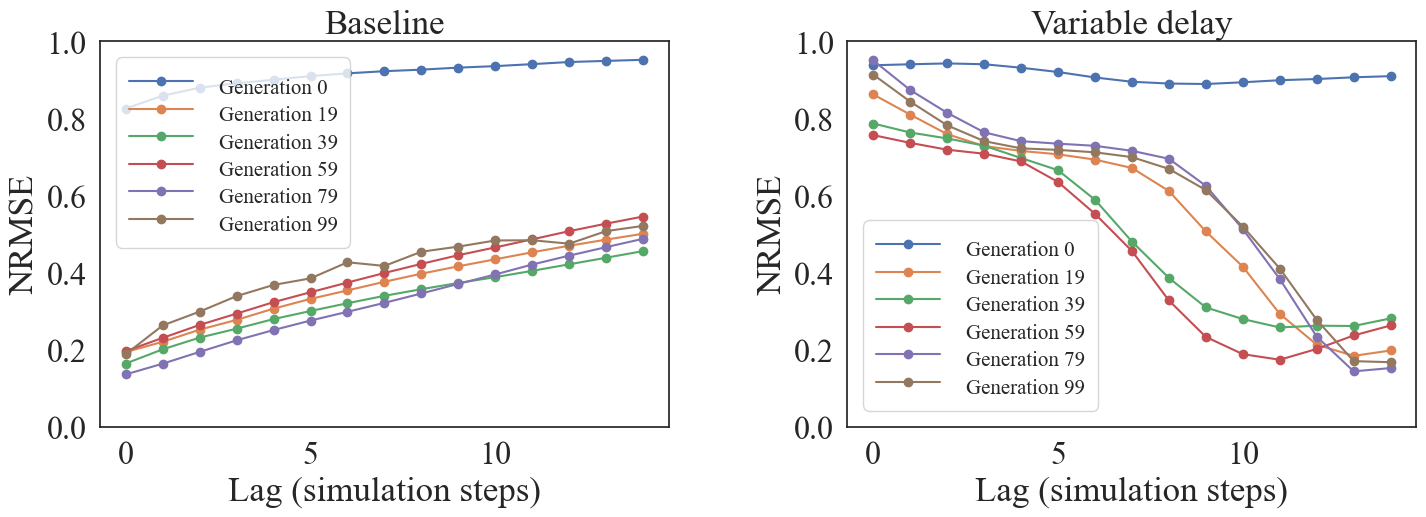

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(16,6.5))
fig.tight_layout(pad=3)
gen_step = 20
plot_lag_info_across_gens(val_vd, ax[1], gen_step, 0)
plot_lag_info_across_gens(val_bl, ax[0], gen_step, 0)
ax[1].set_title('Variable delay')
ax[0].set_title('Baseline')
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
# fig.suptitle('Average performance per lag throughout evolution')
leg_font = '15'
plt.setp(ax[0].get_legend().get_texts(), fontsize=leg_font) # for legend text
plt.setp(ax[1].get_legend().get_texts(), fontsize=leg_font) # for legend text